## Creating Figures
Date: 7/24/2024  
Conda: comad_EAC_figures (in both here and terminal)  
[If trying to get RPCA, then cond: comad (in both here and terminal) -- think this should work for everything in here?

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

import biom
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.diversity.pipelines import alpha
from qiime2.plugins.diversity.visualizers import alpha_rarefaction
from scipy.stats import mannwhitneyu
from qiime2.plugins.emperor.visualizers import biplot
from qiime2.plugins import diversity
from matplotlib.colors import LogNorm
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from qiime2.plugins.diversity_lib.methods import bray_curtis
#from qiime2.plugins.diversity.methods import pcoa ##DO NOT IMPORT becasue u define pcoa in function below
from qiime2.plugins.diversity.methods import pcoa_biplot
from qiime2.plugins import feature_table
from qiime2.plugins.diversity.visualizers import beta_rarefaction

from python_scripts.alpha_beta_diversity import *

###RPCA
import skbio
from emperor import Emperor
import pkg_resources
import q2templates
TEMPLATES = pkg_resources.resource_filename('q2_diversity', '_beta')

##
import inspect
import os
import pkg_resources
import shutil
import tempfile

In [2]:
key_var='_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter'

### Functions

In [3]:
def call_rare(fn, rare_curve=1000):
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t').set_index('sample_name', drop = True)
    q2_meta = Metadata(metadata)
    
    #import tables
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    #Convert table to q2 object
    ft_rs210_genome = Artifact.import_data("FeatureTable[Frequency]", df_rs210_genome.T) 
    
    #Calculate alpha rarefaction curves
    ar_rs210_genome = alpha_rare_curve(ft_rs210_genome, rare_curve, metadata)
    
    #Save objects
    ar_rs210_genome.visualization.save('processed_data/alpha_rarefaction/' + fn + key_var + '.qzv')
    
    return(ar_rs210_genome)

In [4]:
def table_prep_custom(table, fn, rarefaction=None, import_prior=None, save_rare=True):
    
    #Pull exact table from prior rarify runs
    if import_prior != None:
        #Import biplot back into python
        print('Importing prior table', import_prior)
        ft = Artifact.load('processed_data/qza/rare_tables/rare_' + str(rarefaction) + '_' + fn + key_var + import_prior + '.qza')
        return(ft)
    
    #Convert tableto q2 object
    ft = Artifact.import_data("FeatureTable[Frequency]", table.T)
    
    #(Optional) Rarefaction
    if rarefaction != None:
        ft = rarefy(table=ft, sampling_depth = rarefaction)
        ft = ft.rarefied_table
        
        if save_rare == True:
            
            #Save rare ft as pandas df 
            filename ='processed_data/pandas_df/rare_tables/rare_' + str(rarefaction) + '_' + fn + key_var + '.tsv'
            df = ft.view(pd.DataFrame).T
            df.to_csv(filename, sep = '\t')

            #Save rare ft as qza
            filename ='processed_data/qza/rare_tables/rare_' + str(rarefaction) + '_' + fn + key_var + '.qza'
            ft.save(filename)

            #Save rare ft as biom
            filename ='processed_data/biom/rare_tables/rare_' + str(rarefaction) + '_' + fn + key_var + '.biom'
            Artifact.export_data(ft, filename)
    
    return(ft)

In [5]:
def alpha_diversity(fn, rarefaction=None, metric='tumor_type', import_prior=None, save_fig=False, save_rare=False):
    
    #Metadata
    meta = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    meta = meta.set_index('sample_name', drop = True)
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    ##Create all Q2 Tables needed for Calculations##
    
    #Prep Table (rare ect). prior to alpha calculations
    ft_genome_rs210 = table_prep_custom(df_rs210_genome, fn, rarefaction=rarefaction, import_prior=import_prior, save_rare=save_rare)
    
    if import_prior != None:
        #Just to see what columns exist in df for figure
        temp_view = ft_genome_rs210.view(pd.DataFrame)
        print(list(temp_view.index))
    
    #Alpha diverstiy, Shannon
    alpha_result_s = alpha(table=ft_genome_rs210, metric='shannon')
    alpha_diversity_s = alpha_result_s.alpha_diversity
    alpha_series_s = alpha_diversity_s.view(pd.Series)
    
    df = pd.merge(meta, alpha_series_s, right_index = True, left_index = True)
    
    metric_list = list(set(df[metric]))
    
    #Shannon p-values
    list_0 = list(df.loc[df[metric] ==  metric_list[0]]['shannon_entropy'])
    list_1 = list(df.loc[df[metric] ==  metric_list[1]]['shannon_entropy'])
    
    #Shannon p-values
    _, pnorm = mannwhitneyu(list_0, list_1)
    spv = 'Mann Whiteny U rank test: p-value =' + str(pnorm)
    print(spv)
    
    #Plotting
    sns.set_theme(style="white")
    plt.figure(figsize=(2, 3))
    
    # Box plot
    sns.boxplot(x='tumor_type', y='shannon_entropy', data=df, showfliers=False)  
        
    # Strip plot
    sns.stripplot(x='tumor_type', y='shannon_entropy', data=df, color='black', size=4, jitter=True)  
   
    plt.tight_layout()
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    
    if rarefaction != None:
        fn = fn + '_' + str(rarefaction)
    
    if save_fig == True:
        plt.savefig('figures/' + fn + key_var + '_alpha_shannon.svg')
        
    plt.show()

In [6]:
def call_alpha_avg(fn, metric, rarefaction=1000, numRares=10, open_prior=False):
    
    if open_prior !=False:
        
        df_rs210_alpha_rare_genome = pd.read_csv('outputs/alpha_averages/' + fn + key_var + '_' + str(rarefaction) + open_prior + '.tsv', sep='\t')
        display(df_rs210_alpha_rare_genome)
        
        #Display mean
        print(df_rs210_alpha_rare_genome.mean())
        
        return(df_rs210_alpha_rare_genome)
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    df_rs210_alpha_rare_genome = alpha_figures(df_rs210_genome, metadata, rarefaction, metric, numRares= numRares)
    
    #Save alpha diversity dataframe
    df_rs210_alpha_rare_genome.to_csv('outputs/alpha_averages/' + fn + key_var + '_' + str(rarefaction) + '.tsv' , sep='\t', index=False)
    
    return(df_rs210_genome, df_rs210_alpha_rare_genome)

In [7]:
def rpca_rare(fn, rarefaction=550, metric='tumor_type', import_prior=None, permutations=999, save_rare=False):
    
    #Metadata
    meta = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    meta = meta.set_index('sample_name', drop = True)
    q2_meta = q2.Metadata(meta)
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    #RS210
    ft_genome_rs210 = table_prep_custom(df_rs210_genome, fn, rarefaction=rarefaction, import_prior=import_prior, save_rare=save_rare)
    ft_genome_rs210.save('processed_data/decoide/deicode_processing_genome_rs210_rare.qza')
    
    #Run deicode from command line using qza created above - Different settings for blood/tissue due to depth
    if 'blood' in fn:
        #BLOOD
        !qiime deicode rpca --i-table processed_data/decoide/deicode_processing_genome_rs210_rare.qza --p-min-sample-count 10 --o-biplot processed_data/decoide/deicode_biplot_genome_rs210_rare.qza --o-distance-matrix processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza
    else:
        #TISSUE
        !qiime deicode rpca --i-table processed_data/decoide/deicode_processing_genome_rs210_rare.qza --p-min-sample-count 2 --p-min-feature-count 2 --o-biplot processed_data/decoide/deicode_biplot_genome_rs210_rare.qza --o-distance-matrix processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza
    
    #Import biplot back into python
    rpca_biplot = Artifact.load('processed_data/decoide/deicode_biplot_genome_rs210_rare.qza')
    
    #Import biplot back into python
    rpca_distance_matrix = Artifact.load('processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza')
    
    #Create emperor visualization from the biplot result
    rpca_biplot_emperor, = biplot(biplot = rpca_biplot, sample_metadata = q2_meta)
    rpca_biplot_emperor.save('processed_data/RPCA/biplot_' + 'rare_' + str(rarefaction) + '_' + fn + key_var + '.qzv')
    
    #Calculate permanova 
    beta_result_o, = diversity.actions.beta_group_significance(distance_matrix=rpca_distance_matrix, metadata=q2_meta.get_column(metric), method = 'permanova', pairwise = True, permutations=permutations)
    beta_result_o.save('processed_data/RPCA/beta_' + 'rare_' + str(rarefaction) + '_' + fn + key_var + '.qzv')
    
    return(rpca_biplot_emperor, beta_result_o)

In [8]:
def call_beta(fn, metric, rarefaction=1000, numRares=10, open_prior=False):
    
    if open_prior != False:
        
        df_rs210_rpca_rare_genome = pd.read_csv('outputs/permanova_averages/' + fn + key_var + '_' + str(rarefaction) + open_prior + '.tsv', sep='\t')
        display(df_rs210_rpca_rare_genome)
        
        #Display mean
        print(df_rs210_rpca_rare_genome.mean())
        
        return(df_rs210_rpca_rare_genome)
    
    #Metadata
    metadata = pd.read_csv('processed_data/metadata/metadata_' + fn + '.tsv', sep='\t')
    
    #biom tables in df format
    df_rs210_genome = pd.read_csv('processed_data/pandas_df/' + fn + key_var + '.tsv' , sep='\t', index_col = 0)
    
    df_rs210_rpca_rare_genome, dm_list, hcc_med_list, crc_med_list, leftover_med_list = beta_figures(df_rs210_genome, metadata, rarefaction, metric, fn, numRares= numRares)
    
    ### Work on distance matrixs
    
    # Stack the DataFrames into a single 3D numpy array
    stacked = pd.concat(dm_list, axis=0).groupby(level=0)

    # Compute the average (mean) across the DataFrames
    mean_df = stacked.mean()
    mean_df = mean_df.reindex(index=mean_df.columns, columns=mean_df.columns)

    # Compute the median across the DataFrames
    median_df = stacked.median()
    median_df = median_df.reindex(index=median_df.columns, columns=median_df.columns) #Reorder
    
    #Permanova of median
    median_dm = DistanceMatrix(median_df.values, ids=median_df.index)
    median_dm = Artifact.import_data('DistanceMatrix', median_dm)
    
    sample_meta = q2.Metadata(metadata.set_index('sample_name'))
    beta_result_median, = diversity.actions.beta_group_significance(distance_matrix=median_dm,
                                                              metadata=sample_meta.get_column("tumor_type"),
                                                              method = 'permanova', pairwise = True,
                                                              permutations=999)
    
    #Permanova of mean
    mean_dm = DistanceMatrix(mean_df.values, ids=mean_df.index)
    mean_dm = Artifact.import_data('DistanceMatrix', mean_dm)
    
    sample_meta = q2.Metadata(metadata.set_index('sample_name'))
    beta_result_mean, = diversity.actions.beta_group_significance(distance_matrix=mean_dm,
                                                              metadata=sample_meta.get_column("tumor_type"),
                                                              method = 'permanova', pairwise = True,
                                                              permutations=999)
    
    #Save beta diversity dataframe
    df_rs210_rpca_rare_genome.to_csv('outputs/permanova_averages/' + fn + key_var + '_' + str(rarefaction) + '.tsv' , sep='\t', index=False)
    
    #Run RPCA Jackknife
    #RPCA_jackknife(dm_list)
    
    return(df_rs210_rpca_rare_genome, beta_result_mean, beta_result_median, hcc_med_list, crc_med_list, leftover_med_list, mean_dm, median_dm)

### Alpha Rarefaction Curve 

In [9]:
ar_rs210_genome = call_rare('blood_HCC_v_CRC', 600)
ar_rs210_genome.visualization

<visualization: Visualization uuid: a3ce0ff1-a9d0-4a38-be66-02aca5abd82e>

In [10]:
ar_rs210_genome = call_rare('adj_HCC_v_CRC', 60)
ar_rs210_genome.visualization

<visualization: Visualization uuid: cc71f1f1-e549-4aae-9d66-1aeebd11fc85>

In [11]:
ar_rs210_genome = call_rare('tumor_HCC_v_CRC', 60)
ar_rs210_genome.visualization

<visualization: Visualization uuid: 5a41902a-ebf4-4024-b67f-fd372a1509ad>

### [Not in paper] Alpha Diversity Rarefaction Averages
Note: We have low sample count so we get slightly different things when rarifying so in order to fix this we take an average across 50 random rarefactions

##### Reproduce Similar Tables Random Rarefy

In [22]:
alpha_avg = call_alpha_avg('blood_HCC_v_CRC', 'tumor_type', rarefaction=100, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.246889
1,0.264489
2,0.130874
3,0.273484
4,0.381670
5,0.340688
6,0.246889
7,0.169022
8,0.229936
9,0.142867


p-value    0.270108
dtype: float64


In [72]:
#(supplemental figure)
alpha_avg = call_alpha_avg('adj_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.324812
1,0.310719
2,0.218063
3,0.229931
4,0.162314
5,0.282615
6,0.133905
7,0.500000
8,0.205665
9,0.173024


p-value    0.263523
dtype: float64


In [81]:
#(supplemental figure)
alpha_avg = call_alpha_avg('tumor_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50)

RS210 Alpha Rare Genome


,p-value
0,0.428545
1,0.471506
2,0.443193
3,0.485640
4,0.485725
5,0.457332
6,0.296051
7,0.307110
8,0.223429
9,0.428896


p-value    0.368389
dtype: float64


##### Show exact p-value tables used in paper

In [39]:
alpha_avg = call_alpha_avg('blood_HCC_v_CRC', 'tumor_type', rarefaction=100, numRares=50, open_prior='_fig')

,p-value
0,0.246889
1,0.264489
2,0.130874
3,0.273484
4,0.381670
5,0.340688
6,0.246889
7,0.169022
8,0.229936
9,0.142867


p-value    0.270108
dtype: float64


In [73]:
alpha_avg = call_alpha_avg('adj_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50, open_prior='_fig')

,p-value
0,0.324812
1,0.310719
2,0.218063
3,0.229931
4,0.162314
5,0.282615
6,0.133905
7,0.500000
8,0.205665
9,0.173024


p-value    0.263523
dtype: float64


In [82]:
alpha_avg = call_alpha_avg('tumor_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50, open_prior='_fig')

,p-value
0,0.428545
1,0.471506
2,0.443193
3,0.485640
4,0.485725
5,0.457332
6,0.296051
7,0.307110
8,0.223429
9,0.428896


p-value    0.368389
dtype: float64


### [Not in paper] Alpha Diversity Plots

##### Reproduce Similar Graph with Random Rarefy

Mann Whiteny U rank test: p-value =0.11959473207731469


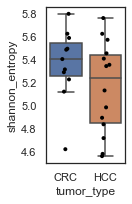

In [50]:
alpha_diversity('blood_HCC_v_CRC', rarefaction=100, save_fig=False, save_rare=False)

Mann Whiteny U rank test: p-value =0.05485278035533292


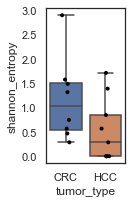

In [40]:
#(supplemental figure)
alpha_diversity('adj_HCC_v_CRC', rarefaction=20, save_fig=False, save_rare=False)

Mann Whiteny U rank test: p-value =0.4820778693451589


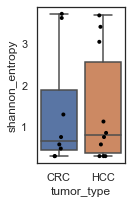

In [88]:
#(supplemental figure)
alpha_diversity('tumor_HCC_v_CRC', rarefaction=20, save_fig=False, save_rare=False)

##### Show exact plot & p-value used in paper 

Importing prior table _fig
['15336.HCC.3.Plasma', '15336.HCC.1.Plasma', '15336.HCC.15.Plasma', '15336.CRC.2.Plasma', '15336.CRC.4.Plasma', '15336.HCC.2.Plasma', '15336.CRC.10.Plasma', '15336.CRC.8.Plasma', '15336.HCC.11.Plasma', '15336.HCC.9.Plasma', '15336.CRC.1.Plasma', '15336.HCC.7.Plasma', '15336.CRC.7.Plasma', '15336.HCC.6.Plasma', '15336.CRC.5.Plasma', '15336.CRC.11.Plasma', '15336.HCC.13.Plasma', '15336.HCC.8.Plasma', '15336.HCC.12.Plasma', '15336.HCC.4.Plasma', '15336.CRC.6.Plasma', '15336.CRC.3.Plasma', '15336.CRC.9.Plasma', '15336.HCC.5.Plasma', '15336.HCC.10.Plasma']
Mann Whiteny U rank test: p-value =0.2299364915141328


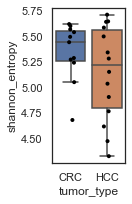

In [69]:
alpha_diversity('blood_HCC_v_CRC', rarefaction=100, import_prior='_fig')

Importing prior table _fig
['15336.CRC.9.Background', '15336.HCC.12.Background', '15336.CRC.8.Background', '15336.HCC.4.Background', '15336.HCC.2.Background', '15336.HCC.15.Background', '15336.HCC.11.Background', '15336.HCC.7.Background', '15336.CRC.4.Background', '15336.HCC.3.Background', '15336.CRC.1.Background', '15336.CRC.6.Background', '15336.CRC.7.Background', '15336.HCC.16.Background', '15336.HCC.5.Background', '15336.CRC.2.Background', '15336.HCC.6.Background', '15336.CRC.11.Background', '15336.CRC.5.Background']
Mann Whiteny U rank test: p-value =0.2165294605083784


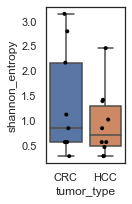

In [74]:
alpha_diversity('adj_HCC_v_CRC', rarefaction=20, import_prior='_fig')

Importing prior table _fig
['15336.CRC.1.tumor', '15336.CRC.10.tumor', '15336.HCC.2.tumor', '15336.HCC.14.tumor', '15336.CRC.5.tumor', '15336.CRC.4.tumor', '15336.CRC.9.tumor', '15336.HCC.6.tumor', '15336.CRC.3.tumor', '15336.HCC.15.tumor', '15336.CRC.11.tumor', '15336.HCC.9.tumor', '15336.HCC.11.tumor', '15336.CRC.7.tumor', '15336.HCC.1.tumor', '15336.HCC.10.tumor', '15336.HCC.4.tumor', '15336.HCC.7.tumor', '15336.HCC.8.tumor', '15336.HCC.16.tumor', '15336.CRC.6.tumor']
Mann Whiteny U rank test: p-value =0.3304468259893236


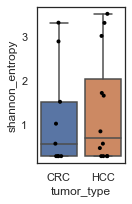

In [85]:
alpha_diversity('tumor_HCC_v_CRC', rarefaction=20, import_prior='_fig')

### Beta Diversity: RPCA

#### Permanova Avg. of Rare Results

##### Reproduce Similar Table with Random Rarefy

###### Blood HCC v CRC

In [27]:
df_rs210_rpca_rare_genome = call_beta('blood_HCC_v_CRC', 'tumor_type', rarefaction=100, numRares=50)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.007,5.073644,25.0
1,0.038,3.207969,25.0
2,0.006,4.729691,25.0
3,0.034,3.685150,25.0
4,0.019,4.195958,25.0
5,0.010,4.642569,25.0
6,0.005,5.469520,25.0
7,0.003,6.841453,25.0
8,0.048,3.152491,25.0
9,0.019,3.859490,25.0


p-value         0.019840
pseudo-F        4.626017
Sample Size    25.000000
dtype: float64


<Figure size 432x288 with 0 Axes>

###### Adj HCC v CRC (supplemental figure)

In [76]:
df_rs210_rpca_rare_genome = call_beta('adj_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50, open_prior=False)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.352,1.080322,19.0
1,0.716,0.472781,19.0
2,0.802,0.341379,19.0
3,0.256,1.215005,19.0
4,0.835,0.248815,19.0
5,0.089,2.284596,19.0
6,0.257,1.143339,19.0
7,0.528,0.657509,19.0
8,0.748,0.346038,19.0
9,0.354,1.206684,19.0


p-value         0.49330
pseudo-F        0.94916
Sample Size    19.00000
dtype: float64


<Figure size 432x288 with 0 Axes>

###### Tissue HCC v CRC (supplemental figure)

In [86]:
df_rs210_rpca_rare_genome = call_beta('tumor_HCC_v_CRC', 'tumor_type', rarefaction=20, numRares=50)


RS210 RPCA Rare Genome


,p-value,pseudo-F,Sample Size
0,0.786,0.507129,21.0
1,0.616,0.670776,21.0
2,0.705,0.571866,21.0
3,0.941,0.287923,21.0
4,0.533,0.781008,21.0
5,0.395,0.980256,21.0
6,0.555,0.786837,21.0
7,0.711,0.507164,21.0
8,0.468,0.981933,21.0
9,0.873,0.203629,21.0


p-value         0.537220
pseudo-F        0.894777
Sample Size    21.000000
dtype: float64


<Figure size 432x288 with 0 Axes>

##### Show p-value tables used in manuscript

In [28]:
df_rs210_rpca_rare_genome = call_beta('blood_HCC_v_CRC', 'tumor_type', rarefaction=100, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.007,5.073644,25.0
1,0.038,3.207969,25.0
2,0.006,4.729691,25.0
3,0.034,3.685150,25.0
4,0.019,4.195958,25.0
5,0.010,4.642569,25.0
6,0.005,5.469520,25.0
7,0.003,6.841453,25.0
8,0.048,3.152491,25.0
9,0.019,3.859490,25.0


p-value         0.019840
pseudo-F        4.626017
Sample Size    25.000000
dtype: float64


In [77]:
df_rs210_rpca_rare_genome = call_beta('adj_HCC_v_CRC', 'tumor_type', rarefaction=20, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.352,1.080322,19.0
1,0.716,0.472781,19.0
2,0.802,0.341379,19.0
3,0.256,1.215005,19.0
4,0.835,0.248815,19.0
5,0.089,2.284596,19.0
6,0.257,1.143339,19.0
7,0.528,0.657509,19.0
8,0.748,0.346038,19.0
9,0.354,1.206684,19.0


p-value         0.49330
pseudo-F        0.94916
Sample Size    19.00000
dtype: float64


In [87]:
df_rs210_rpca_rare_genome = call_beta('tumor_HCC_v_CRC', 'tumor_type', rarefaction=20, open_prior='_fig')

,p-value,pseudo-F,Sample Size
0,0.786,0.507129,21.0
1,0.616,0.670776,21.0
2,0.705,0.571866,21.0
3,0.941,0.287923,21.0
4,0.533,0.781008,21.0
5,0.395,0.980256,21.0
6,0.555,0.786837,21.0
7,0.711,0.507164,21.0
8,0.468,0.981933,21.0
9,0.873,0.203629,21.0


p-value         0.537220
pseudo-F        0.894777
Sample Size    21.000000
dtype: float64


#### RPCA Plot + P-value of Rare RPCA

##### Reproduce Similar Graph and p-value with Random Rarefy

###### Blood HCC vs. CRC

In [30]:
rpca_biplot_emperor, beta_result_o  = rpca_rare('blood_HCC_v_CRC', rarefaction=100, permutations=999)
beta_result_o

Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 49ad1f2a-adbe-4378-81f4-46876e8ca035>

<Figure size 432x288 with 0 Axes>

In [15]:
rpca_biplot_emperor

<visualization: Visualization uuid: 2c35f114-52f5-405b-a344-3bf370356d52>

###### Adj HCC vs. CRC

In [12]:
rpca_biplot_emperor, beta_result_o  = rpca_rare('adj_HCC_v_CRC', rarefaction=20)
beta_result_o

TISSUE
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: f6c001e2-85ab-4a7e-890e-1a6cdbb4ae49>

<Figure size 432x288 with 0 Axes>

In [19]:
rpca_biplot_emperor

<visualization: Visualization uuid: 76c63157-67e3-4d19-8861-51fb693c2a0c>

###### Tumor HCC vs. CRC

In [74]:
rpca_biplot_emperor, beta_result_o = rpca_rare('tumor_HCC_v_CRC', rarefaction=20)
beta_result_o

Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 386837ce-4a65-45c6-9abc-d188819f5b4d>

<Figure size 432x288 with 0 Axes>

In [75]:
rpca_biplot_emperor

<visualization: Visualization uuid: 5b6305bb-6d9b-4b07-a688-e08486521654>

##### Show exact plot & p-value used in paper

###### Blood HCC vs. CRC

In [64]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('blood_HCC_v_CRC', rarefaction=100, import_prior='_fig')
beta_result_o

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 1beec37e-b896-4102-8dea-4bf7fd506f3a>

<Figure size 432x288 with 0 Axes>

In [65]:
rpca_biplot_emperor

<visualization: Visualization uuid: 41213b1c-2a96-4b6f-aff2-ec16ba115644>

In [66]:
#Beta p-value -- Exact one used in paper (you have to do this way because permanova slightly different every time)

beta = Visualization.load('processed_data/RPCA/beta_rare_100_blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: 1beec37e-b896-4102-8dea-4bf7fd506f3a>

In [68]:
#Save QZV file to import into birmand

# Load the QIIME 2 Artifact
table_artifact = Artifact.load('processed_data/qza/rare_tables/rare_100_blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter_fig.qza')

# Export the artifact to a directory
table_artifact.export_data('processed_data/biom/rare_tables/rare_100_blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter_fig.biom')


###### Adj HCC vs. CRC

In [78]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('adj_HCC_v_CRC', rarefaction=20, import_prior='_fig')
rpca_biplot_emperor

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: 057a6133-4dc3-4508-9d58-443183a64c51>

<Figure size 432x288 with 0 Axes>

In [79]:
beta_result_o

<visualization: Visualization uuid: 2714690d-befb-4eaa-8a19-7f9f64208747>

In [80]:
#Beta p-value -- Exact one used in paper
beta = Visualization.load('processed_data/RPCA/beta_rare_20_adj_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: 2714690d-befb-4eaa-8a19-7f9f64208747>

###### Tumor HCC vs. CRC

In [88]:
#Note: This uses the same table so should get the same rpca plot but might get slightly different beta results due to permanova
#Note: this _fig just refers to the same _fig rare table not the 'figure' from the permanova
rpca_biplot_emperor, beta_result_o = rpca_rare('tumor_HCC_v_CRC', rarefaction=20, import_prior='_fig')
rpca_biplot_emperor

Importing prior table _fig
Saved PCoAResults % Properties('biplot') to: processed_data/decoide/deicode_biplot_genome_rs210_rare.qza
Saved DistanceMatrix to: processed_data/decoide/deicode_distance_matrix_genome_rs210_rare.qza


<visualization: Visualization uuid: b2691223-37af-4de1-b68b-19acdb9f80a2>

<Figure size 432x288 with 0 Axes>

In [89]:
beta_result_o

<visualization: Visualization uuid: 08ac426c-7e3b-4e05-90df-bd40150042fb>

In [90]:
#Beta p-value -- Exact one used in paper
beta = Visualization.load('processed_data/RPCA/beta_rare_20_tumor_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter_figure.qzv')

# View the QZV file -- saved from here
beta

<visualization: Visualization uuid: 08ac426c-7e3b-4e05-90df-bd40150042fb>

### Abudance Maps

In [18]:
#Pull the top 10 upper/lower GOTUs from birdman , then subset df by them
birdman_df = pd.read_csv('figures/blood_HCC_v_CRC' + key_var + '.tsv', sep = '\t')

#Import biom tables in df format
df_rs210_genome = pd.read_csv('processed_data/pandas_df/blood_HCC_v_CRC' + key_var + '.tsv' , sep='\t', index_col = 0)

#Subset df by feature
birdman_rs210 = df_rs210_genome.loc[birdman_df['Feature'].to_list()]
#birdman_rs210['GOTU'] = birdman_rs210.index

In [19]:
# Reset index and melt the DataFrame
melt_birdman = pd.melt(birdman_rs210.reset_index(), id_vars='index', var_name='sample_name', value_name='count')

#Add in other helpful columns from birdman run
sample_dict_tax = dict(zip(birdman_df['Feature'], birdman_df['gOTU_Taxonomy']))
sample_dict_mean = dict(zip(birdman_df['Feature'], birdman_df['tumor_type[T.HCC]_mean']))
melt_birdman['gOTU_Taxonomy'] = melt_birdman['index'].map(sample_dict_tax)
melt_birdman['tumor_type[T.HCC]_mean'] = melt_birdman['index'].map(sample_dict_mean)
melt_birdman['mean_taxonomy'] = melt_birdman['tumor_type[T.HCC]_mean'].astype(int).astype(str) + '_' + melt_birdman['gOTU_Taxonomy']
melt_birdman['tumor_type_mean'] = np.where(melt_birdman['tumor_type[T.HCC]_mean'] < 0, 'CRC', 'HCC')
melt_birdman['mean_taxonomy_def'] = melt_birdman['tumor_type_mean'] + ' : ' + melt_birdman['gOTU_Taxonomy']

# Create a heatmap
#plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
birdman_map = melt_birdman.pivot(index="mean_taxonomy_def", columns="sample_name", values="count")

#Re-order to match birdman output
birdman_map.reset_index(inplace=True)
order = melt_birdman['mean_taxonomy_def'].unique()
birdman_map = birdman_map.set_index('mean_taxonomy_def').loc[order]

#### [Not in paper] Heatmap

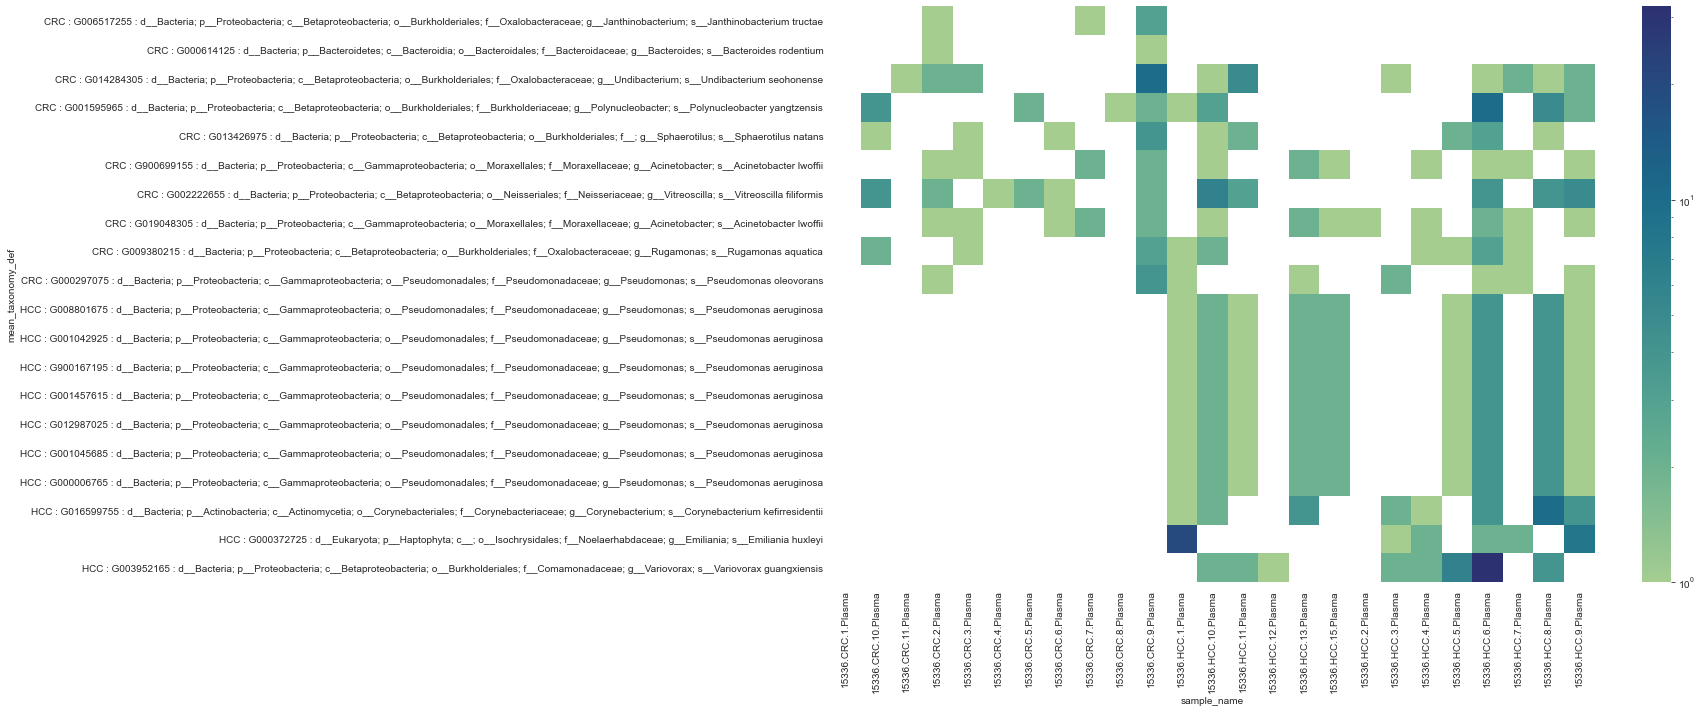

In [20]:
fig, ax = plt.subplots(figsize=(25, 10))

sns.heatmap(birdman_map, norm=LogNorm(), cmap="crest") #annot=True, vmin=0, vmax=20)

# Display the heatmap
plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
#plt.savefig('figures/birdman_abundance_heatmap.svg')
plt.show()

#### Cluster Map

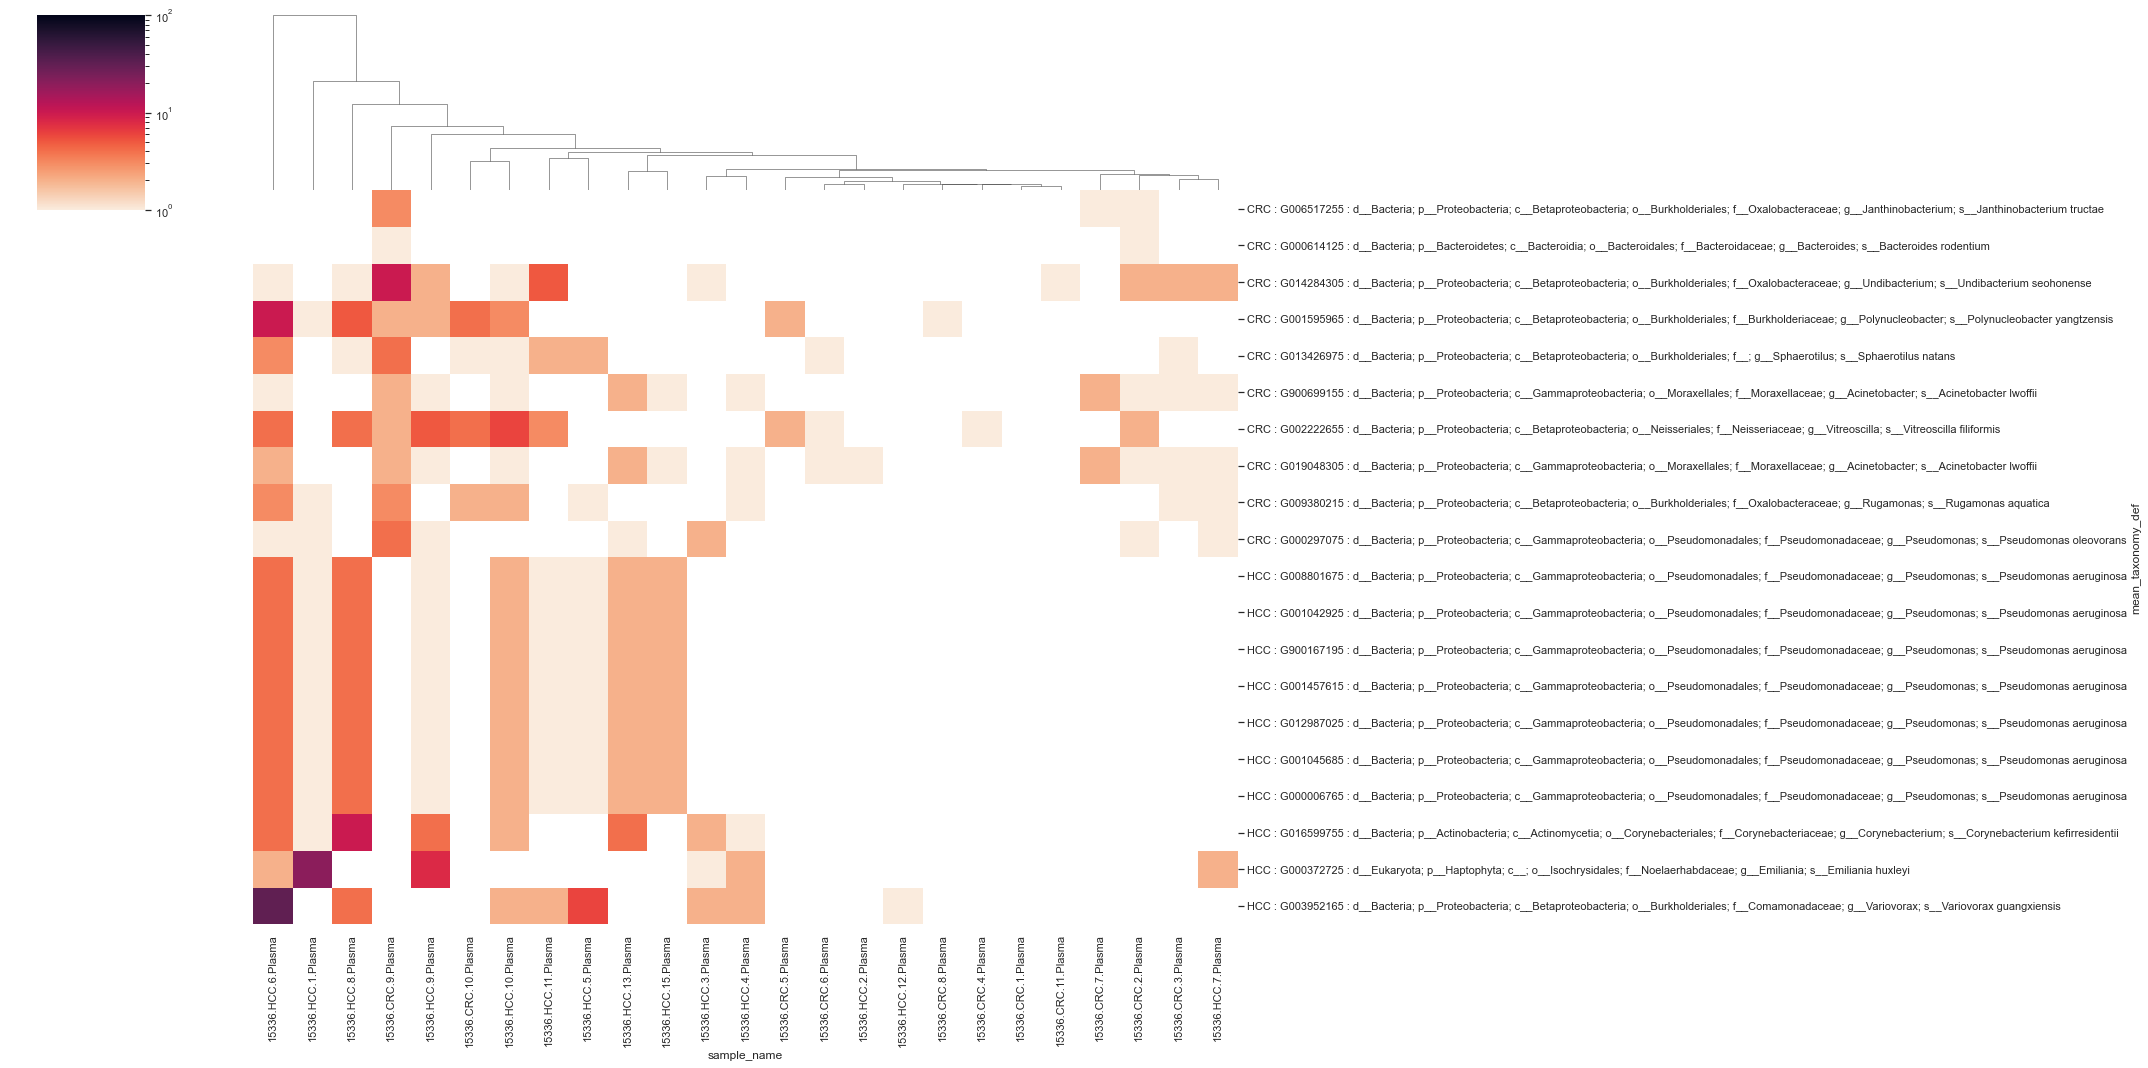

In [96]:
# Create a cluster map and set colorbar normalization
sns.clustermap(birdman_map, norm=LogNorm(vmin=1, vmax=100), cmap="rocket_r",
               row_cluster=False, col_cluster=True, 
               #norm=SymLogNorm(linthresh=10,vmin=0, vmax=birdman_map.max().max()),
               figsize=(30, 15), method='complete') #complete, average, ward

#plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
plt.savefig('figures/birdman_abundance_clustermap.svg')
plt.show()

#### Average Columns

/Users/cguccion/miniconda3/envs/comad/lib/python3.8/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


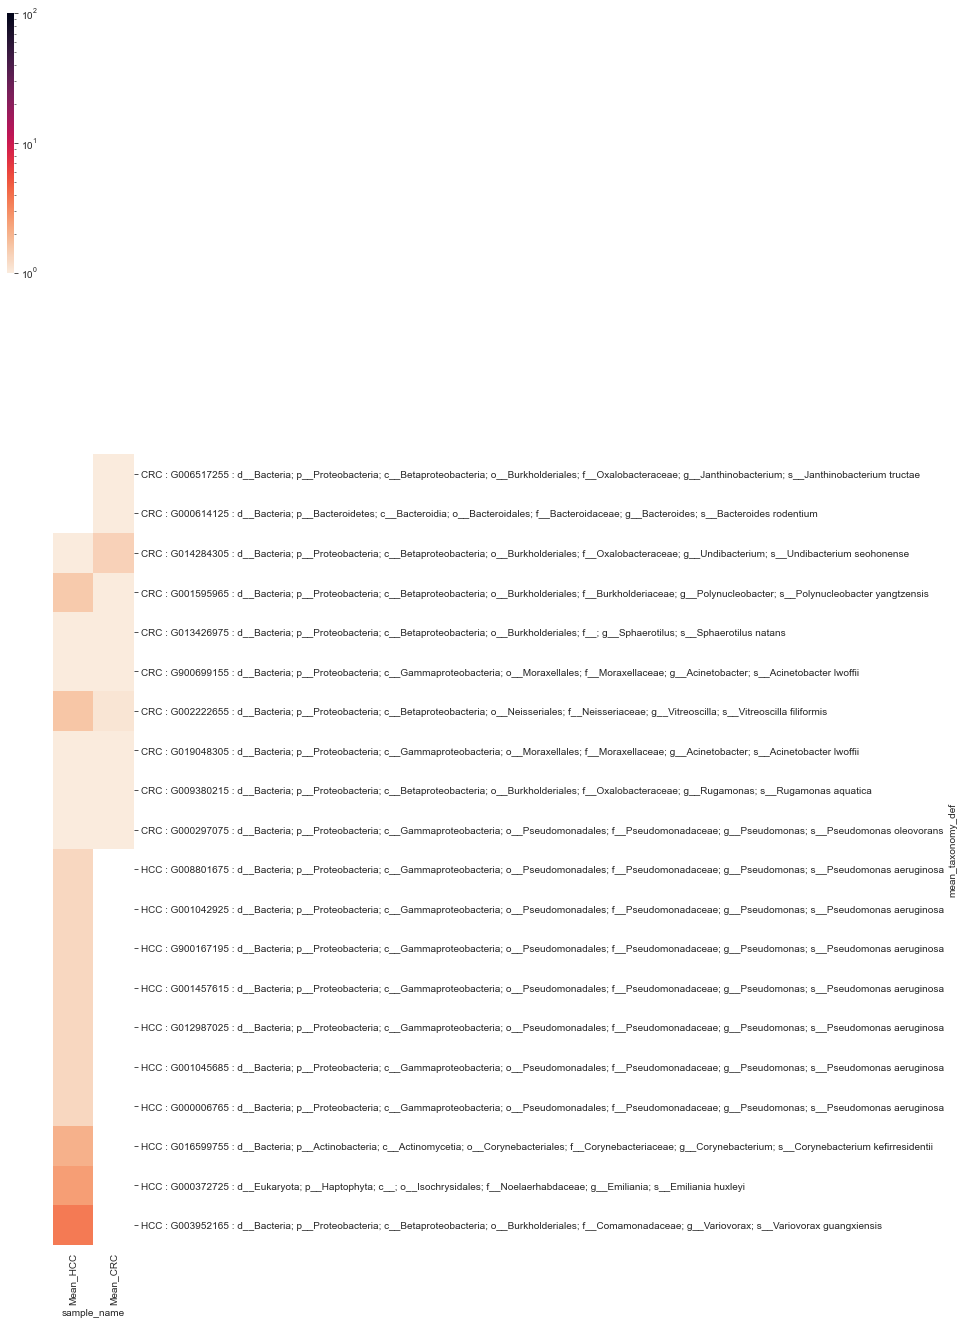

In [21]:
birdman_col = birdman_map.copy()

# Select columns containing 'HCC' or 'CRC'
hcc_columns = birdman_col.filter(like='HCC').columns
crc_columns = birdman_col.filter(like='CRC').columns

# Calculate mean along the selected columns for each row
birdman_col['Mean_HCC'] = birdman_col[hcc_columns].mean(axis=1)
birdman_col['Mean_CRC'] = birdman_col[crc_columns].mean(axis=1)

# Drop unnecessary columns
birdman_col = birdman_col.loc[:, birdman_col.columns.get_level_values(0).isin(['mean_taxonomy_def', 'Mean_HCC', 'Mean_CRC'])]

sns.clustermap(birdman_col, norm=LogNorm(vmin=1, vmax=100), cmap="rocket_r",
               row_cluster=False, col_cluster=False, 
               figsize=(2, 20))

#plt.tight_layout()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
#plt.savefig('figures/birdman_abundance_mean.svg')
plt.show()

In [22]:
birdman_map

sample_name,15336.CRC.1.Plasma,15336.CRC.10.Plasma,15336.CRC.11.Plasma,15336.CRC.2.Plasma,15336.CRC.3.Plasma,15336.CRC.4.Plasma,15336.CRC.5.Plasma,15336.CRC.6.Plasma,15336.CRC.7.Plasma,15336.CRC.8.Plasma,...,15336.HCC.13.Plasma,15336.HCC.15.Plasma,15336.HCC.2.Plasma,15336.HCC.3.Plasma,15336.HCC.4.Plasma,15336.HCC.5.Plasma,15336.HCC.6.Plasma,15336.HCC.7.Plasma,15336.HCC.8.Plasma,15336.HCC.9.Plasma
mean_taxonomy_def,,,,,,,,,,,,,,,,,,,,,
CRC : G006517255 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Oxalobacteraceae; g__Janthinobacterium; s__Janthinobacterium tructae,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRC : G000614125 : d__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__Bacteroides rodentium,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRC : G014284305 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Oxalobacteraceae; g__Undibacterium; s__Undibacterium seohonense,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0
CRC : G001595965 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Burkholderiaceae; g__Polynucleobacter; s__Polynucleobacter yangtzensis,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,5.0,2.0
CRC : G013426975 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__; g__Sphaerotilus; s__Sphaerotilus natans,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0
CRC : G900699155 : d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Moraxellales; f__Moraxellaceae; g__Acinetobacter; s__Acinetobacter lwoffii,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,...,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
CRC : G002222655 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Neisseriales; f__Neisseriaceae; g__Vitreoscilla; s__Vitreoscilla filiformis,0.0,4.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0
CRC : G019048305 : d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Moraxellales; f__Moraxellaceae; g__Acinetobacter; s__Acinetobacter lwoffii,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,...,2.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0
CRC : G009380215 : d__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Oxalobacteraceae; g__Rugamonas; s__Rugamonas aquatica,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0
